## Import packages

In [1]:
import utils
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

## Data augmentation parameters

To fix the imbalanced classed problem, you want the augmented data to have a number of samples for species $i$ equal to:
$$ C \times \frac{N}{K} $$
i.e, you want to multiply each class $i$ by a factor:
$$ \frac{N}{n_{i}} \times \frac{C}{K} $$
with:
- $N$ being the total size of the original dataset
- $n_i$ the number of samples for species $i$ in the original dataset
- $C$ the augmentation factor
- $K$ the number of species, i.e K = 8

In [9]:
BALANCE_CLASSES: bool = True # Should the augmented data have as many samples in each species ?
AUGMENTATION_FACTOR: float = 5. # The size factor that we want to multiply our data with
RNG_SEED: int = 42 # The seed for the random effects of data augmentation

# Augmented Data Generator parameters
# Transformations
ROTATION_RANGE: float = 100. # Max rotation in degrees
ZOOM_RANGE: float = 0.4 # Max zoom
WIDTH_SHIFT_RANGE: int = 15 # Horizontal shift (in pixels)
HEIGHT_SHIFT_RANGE: int = 15 # Vertical shift (in pixels)
HORIZONTAL_FLIP: bool = True # Horizontal flip
VERTICAL_FLIP: bool = True # Vertical flip
BRIGHTNESS_SHIFT_RANGE: list[float] = [0.4, 1.4] # Minimum and max brightness scaling
SHEAR_RANGE: float = 10. # Max shear in degrees

FILL_MODE: str = "reflect" # Filling method for out-of-border pixels

__Question:__  
Does an augmented data generator object apply different random transformations at each epoch ?

__Answer:__  
Yes it does, augmentation happens epoch-wise, which means the `AUGMENTATION_FACTOR` parameter is irrelevant.  

**BUT** it's merely a pipe which outflows the same (augmented) images that it's been fed with, which means the augmented dataset will still have unbalanced classes if we flow directly from directory
  
__Questions:__
- Is that a problem that we train using a class-imbalanced dataset ? 
- If it is, then we have 2 options:  
  -  **loss weighting** (built-in `TensorFlow` through the `class_weight` parameter of the method `Model.fit(...)`)
  -  **balancing the training dataset somehow**: *How ?*  https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#oversampling  
     -  Oversampling: we use redundant samples in the smaller classes such that for each class $i$, at each epoch we train using $n_i = \max_j{n_j}$ samples. We are obviously at risk of overfitting when it comes to the smaller clases. Hopefully, the data augmentation will be different on each resample so that it should *smooth* the redundancy of the samples, to some extent. We can either try to resample randomly at each epoch or have the same samples be resampled throughout the training.
     -  Subsampling: we cut out the *excess* data in the bigger classes such that for each class $i$, at each epoch we train using $n_i = \min_j{n_j}$ samples. This seems to be the worst option of the two because it throws away perfectly fine and authentic data. That being said, similarly as with oversampling, we can image either subsampling randomly at each epoch, which would compensate for the "lost" data as we would, over many epochs, see the whole data at some point; or we could sample identically across every epoch, which sounds like the absolute worst thing we could do because then we would **definitely** lose the unsampled data.

Number of resamples needed for Species1: 351
Number of resamples needed for Species2: 5
Number of resamples needed for Species3: 22
Number of resamples needed for Species4: 26
Number of resamples needed for Species5: 6
Number of resamples needed for Species6: 315
Number of resamples needed for Species7: 0
Number of resamples needed for Species8: 29


<BarContainer object of 8 artists>

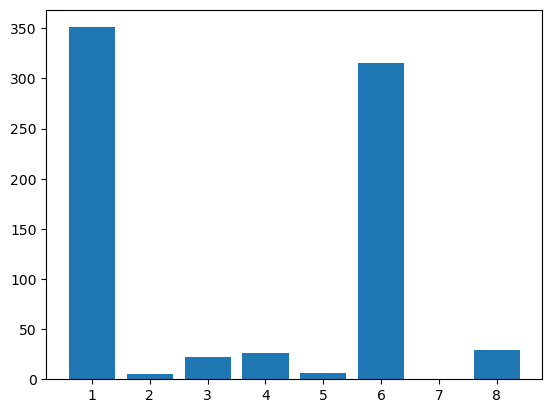

In [4]:
n_resamples: dict[str, int] = {}
for species in utils.labels:
    mi = max(utils.n_images.values()) - utils.n_images[species]
    n_resamples[species] = mi
    print("Number of resamples needed for %s: %d" % (species, mi))

plt.bar(np.arange(1, utils.n_species + 1), n_resamples.values())
#plt.title("Number of resamples needed for each species for equally distributed training data")

## Complete augmentation data generator

In [13]:
complete_aug_data_gen = ImageDataGenerator(
    rotation_range=ROTATION_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE,
    height_shift_range=HEIGHT_SHIFT_RANGE,
    brightness_range=BRIGHTNESS_SHIFT_RANGE,
    shear_range=SHEAR_RANGE,
    zoom_range=ZOOM_RANGE,
    fill_mode=FILL_MODE,
    horizontal_flip=HORIZONTAL_FLIP,
    vertical_flip=VERTICAL_FLIP,
)

In [14]:
aug_data = complete_aug_data_gen.flow_from_directory(
    utils.data_dir,
    target_size = (utils.input_height, utils.input_width),
    seed=RNG_SEED
)

Found 3542 images belonging to 8 classes.


Returned a tuple for each batch containing:
- a np.ndarray of dimension 3 where $a_{ijk}$ is the value of the $k$-th channel in the $j$-th pixel of the $i$-th image
- a 1-dimensional array corresponding to the $i$ labels

### Plot one random image of each class along with a random augmented version of it (randomly transformed according to the data genarator parameters):

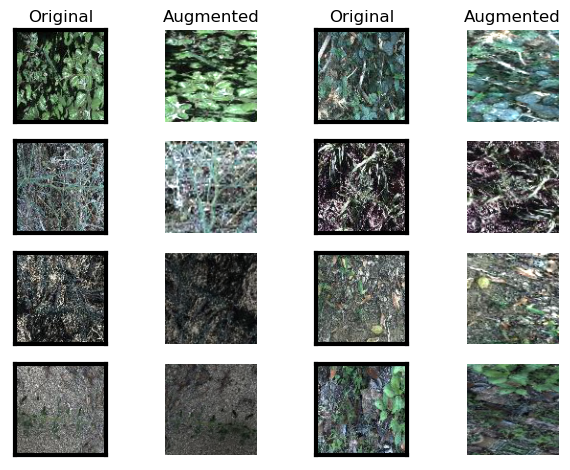

In [54]:
import os
from PIL import Image

np.random.seed(4)

num_row = 4
num_col = 4
fig, axes = plt.subplots(num_row, num_col)
axes = axes.flatten()

for i in range(utils.n_species):
    class_images = os.listdir("{}/{}".format(utils.data_dir, utils.labels[i]))
    img_file = class_images[np.random.randint(len(class_images))]
    img = Image.open('{}/{}/{}'.format(utils.data_dir, utils.labels[i], img_file))
    img_array = np.array(img)
    axes[2*i].imshow(img_array)
    transformed_img = np.array(complete_aug_data_gen.random_transform(img_array), dtype=np.uint8)
    axes[2*i+1].imshow(transformed_img)

    for axis in ['top','bottom','left','right']:
        axes[2*i].spines[axis].set_linewidth(3)
    axes[2*i].xaxis.set_ticklabels([])
    axes[2*i].yaxis.set_ticklabels([])
    axes[2*i].xaxis.set_ticks([])
    axes[2*i].yaxis.set_ticks([])
    # axes[2*i].set_title(f"spec{i} original")
    axes[2*i+1].axis(False)
    # axes[2*i+1].set_title(f"spec{i} transformed")

axes[0].set_title("Original")
axes[1].set_title("Augmented")
axes[2].set_title("Original")
axes[3].set_title("Augmented")

plt.tight_layout()
plt.axis(False)
plt.show()

### Plot one image and variations of it

Found 3542 images belonging to 8 classes.


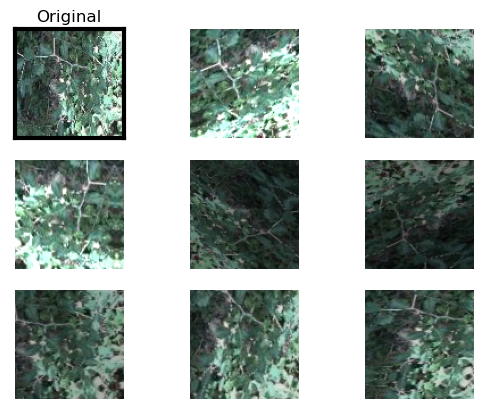

In [52]:
data = ImageDataGenerator().flow_from_directory(utils.data_dir, shuffle=True, seed=RNG_SEED)

np.random.seed(1)
img = np.array(Image.open(data.filepaths[np.random.randint(32)]))

num_row = 3
num_col = 3
fig, axes = plt.subplots(num_row, num_col)
axes = axes.flatten()

axes[0].imshow(img)
axes[0].set_title("Original")

for axis in ['top','bottom','left','right']:
    axes[0].spines[axis].set_linewidth(3)

axes[0].xaxis.set_ticklabels([])
axes[0].yaxis.set_ticklabels([])
axes[0].xaxis.set_ticks([])
axes[0].yaxis.set_ticks([])


for i in range(1, num_row * num_col):
    axes[i].imshow(np.array(complete_aug_data_gen.random_transform(img), dtype=np.uint8))
    axes[i].axis(False)